In [1]:
import drjit as dr
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D import GreenSampling, Split
from mitsuba import Point2f, Float
import time

In [2]:
max_z = 600
majorant = 1000
rad = 1
source_rad = rad/2
source_val = 50.
newton_steps = 3

In [3]:
source_p = {}
source_p["radius"] = source_rad
source_p["val"] = source_val
def source_generator(points, params):
    return dr.select(dr.norm(points) < params["radius"], params["val"], 0.0)

In [4]:
s = 1
bbox = [[-1.05 * rad * s, -1.05 * rad * s], [1.05 * rad * s, 1.05 * rad * s]]
resolution_image = [256, 256]
spp_image = 64
epsilon = 1e-5

dirichlet = ConstantCoefficient("dirichlet", 0)
neumann = ConstantCoefficient("neumann",0)
σ = ConstantCoefficient("screening", 0)
f = FunctionCoefficient("source", source_p, source_generator)
shape = CircleShape(origin=Point2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=[dirichlet])
data_holder = DataHolder(shape = shape, σ = σ, f=f, default_majorant = majorant)

In [5]:
def correct_solution(points, origin, source_val, source_radius, boundary_radius):
    distance = dr.norm(points - origin)
    result = Float(0)
    source_val = Float(source_val)
    source_radius = Float(source_radius)
    boundary_radius = Float(boundary_radius)
    inside = distance < source_radius
    c =  source_val * source_radius**2 / 2 * (0.5 -  np.log(source_radius/boundary_radius))
    inside_val = - source_val * distance ** 2 / 4 + c

    outside = (distance >= source_radius) & (distance<boundary_radius)
    outside_val = - source_val * source_radius**2 /2 * dr.log(distance / boundary_radius)
    
    result = dr.select(inside, inside_val, result)
    result = dr.select(outside, outside_val, result)
    return result

points = create_image_points(bbox, resolution_image, spp_image, centered = True)
L_correct = correct_solution(Point2f(points),Point2f(0), source_val, source_rad, rad)
image_cor, tensor = create_image_from_result(L_correct, resolution_image)

/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 5 Axes> than <Figure size 2000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)
/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 6 Axes> than <Figure size 2000x500 with 5 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)


Eval type : polynomial, sampling type : newton, time = 0.051 s
Eval type : polynomial, sampling type : rejection, time = 0.071 s


/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 7 Axes> than <Figure size 2000x500 with 6 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)


Eval type : analytic, sampling type : newton, time = 0.699 s


/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 8 Axes> than <Figure size 2000x500 with 7 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)


Eval type : analytic, sampling type : rejection, time = 1.088 s


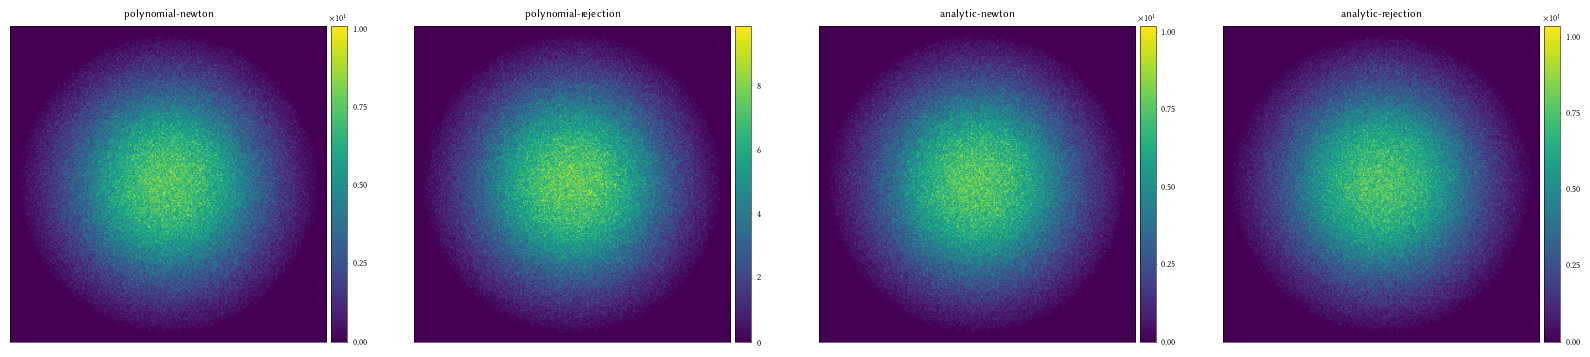

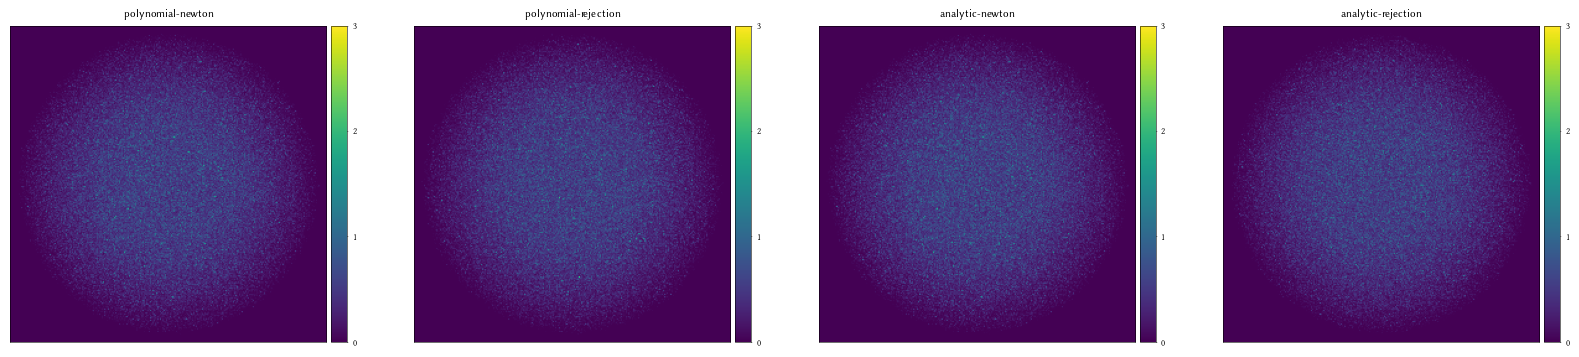

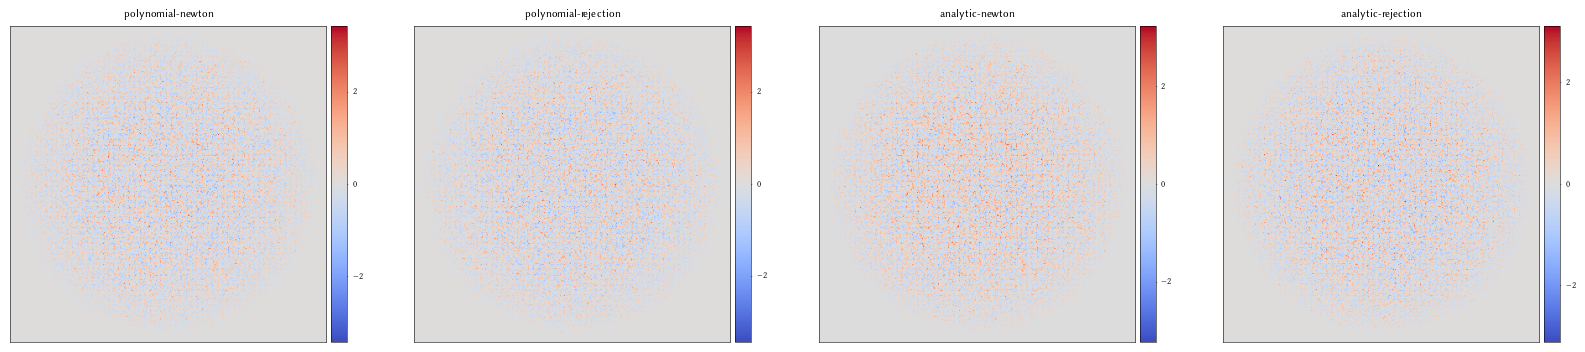

In [6]:

figure1, ax1 = plt.subplots(1,4, figsize = (20,5))
figure2, ax2 = plt.subplots(1,4, figsize = (20,5))
figure3, ax3 = plt.subplots(1,4, figsize = (20,5))
points = create_image_points(bbox, resolution_image, spp_image, centered = True)
i = 0
for type1 in ["polynomial", "analytic"]:
    for type2 in ["newton", "rejection"]:
        
        if (type1 == "polynomial") and (type2 == "newton"):
            wos = WosVariable(data_holder, seed = 21, green_sampling= GreenSampling.Polynomial, newton_steps = newton_steps, use_accelaration = False, max_z = 6)
        elif (type1 == "analytic") and (type2 == "newton"):
            wos = WosVariable(data_holder, seed = 21, green_sampling= GreenSampling.Analytic, newton_steps=newton_steps, use_accelaration= False, max_z = max_z)
        elif (type1 == "polynomial") and (type2 == "rejection"):
            wos = WosVariableRejection(data_holder, seed = 21, green_sampling= GreenSampling.Polynomial, newton_steps=newton_steps, use_accelaration = False, max_z = 6)
        elif (type1 == "analytic") and (type2 == "rejection"):
            wos = WosVariableRejection(data_holder, seed = 21, green_sampling= GreenSampling.Analytic, newton_steps = newton_steps, use_accelaration = False, max_z = max_z)
        else:
            raise Exception("No such case.")
        dr.sync_thread()
        t = time.time()
        L_wos, particle= wos.solve(points_in = points, verbose = False, split = Split.Naive)
        image_wos, tensor, image_variance, tensor_variance = create_image_from_result(L_wos, resolution_image, compute_std=True)
        dr.eval(tensor)
        dr.sync_thread()
        t_last = time.time()
        plot_image(image_wos[0], ax1[i])
        plot_image(image_variance[0], ax2[i], input_range = [0,3])
        diff = image_wos[0] - image_cor[0]
        max_range = max(np.max(diff), np.min(-diff))
        plot_image(image_wos[0] - image_cor[0], ax3[i], input_range = [-max_range, max_range], cmap = "coolwarm")
        ax1[i].set_title(f"{type1}-{type2}")
        ax2[i].set_title(f"{type1}-{type2}")
        ax3[i].set_title(f"{type1}-{type2}")
        i += 1
        print(f"Eval type : {type1}, sampling type : {type2}, time = {(t_last - t):.3f} s")
